# Preparing the Environment

In [1]:
! pip install transformers
! pip install datasets

In [2]:
! pip install seqeval

     |████████████████████████████████| 43 kB 290 kB/s            
  Preparing metadata (setup.py) ... done
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16181 sha256=a127983c90fe5e5d6722f8f0050f498c432afe905fc02f23260a61d317ab9bfa
  Stored in directory: /root/.cache/pip/wheels/05/96/ee/7cac4e74f3b19e3158dce26a20a1c86b3533c43ec72a549fd7
Successfully built seqeval


In [3]:
pip install astor

Note: you may need to restart the kernel to use updated packages.


In [4]:
import ast
import astor
import inspect
import textwrap

def print_source(obj, exclude_doc=True):
    """Helpful for getting documentation"""
    source = inspect.getsource(obj)
    cleaned_source = textwrap.dedent(source)
    parsed = ast.parse(cleaned_source)
    
    for node in ast.walk(parsed):
        if not isinstance(node, (ast.FunctionDef, ast.ClassDef, ast.AsyncFunctionDef)):
            continue
        if exclude_doc and len(node.body) > 1:
            node.body = node.body[1:]
            
    print(astor.to_source(parsed))

# Getting the Dataset

In [5]:
import pandas as pd
pd.set_option('max_colwidth', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

In [6]:
# An Example of how this works
toks = "Jeff Dean is a computer scientist at Google in California".split()
lbls = ["B-PER", "I-PER", "O", "O", "O", "O", "O", "B-ORG", "O", "B-LOC"]
pd.DataFrame(data=[toks, lbls], index=['Tokens', 'Tags'])

,0,1,2,3,4,5,6,7,8,9
Tokens,Jeff,Dean,is,a,computer,scientist,at,Google,in,California
Tags,B-PER,I-PER,O,O,O,O,O,B-ORG,O,B-LOC


In [7]:
# let's load the dataset we need for this task
from datasets import get_dataset_config_names

xtreme_subsets = get_dataset_config_names('xtreme')
print(f'XTREME has {len(xtreme_subsets)} configurations')

Downloading:   0%|          | 0.00/9.04k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/23.1k [00:00<?, ?B/s]

XTREME has 183 configurations


In [8]:
panx_subsets = [s for s in xtreme_subsets if s.startswith('PAN')]
len(panx_subsets),panx_subsets[:3]

(40, ['PAN-X.af', 'PAN-X.ar', 'PAN-X.bg'])

In [9]:
from datasets.load import load_dataset
from collections import defaultdict
from datasets import DatasetDict

langs = ['de', 'fr', 'it', 'en']
fracs = [0.629, 0.229, 0.084, 0.059]
panx_ch = defaultdict(DatasetDict)

for lang, frac in zip(langs, fracs):
  # load monolingual corpus
  ds = load_dataset('xtreme', name=f'PAN-X.{lang}')
  # shuffle and downsample each split according to spoken proportion
  for split in ds:
    panx_ch[lang][split] = (ds[split].shuffle(seed=0).select(range(int(frac * ds[split].num_rows))))

Downloading:   0%|          | 0.00/234M [00:00<?, ?B/s]

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

Dataset xtreme downloaded and prepared to /root/.cache/huggingface/datasets/xtreme/PAN-X.de/1.0.0/2fc6b63c5326cc0d1f73060649612889b3a7ed8a6605c91cecdbd228a7158b17. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

Dataset xtreme downloaded and prepared to /root/.cache/huggingface/datasets/xtreme/PAN-X.fr/1.0.0/2fc6b63c5326cc0d1f73060649612889b3a7ed8a6605c91cecdbd228a7158b17. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

Dataset xtreme downloaded and prepared to /root/.cache/huggingface/datasets/xtreme/PAN-X.it/1.0.0/2fc6b63c5326cc0d1f73060649612889b3a7ed8a6605c91cecdbd228a7158b17. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

Dataset xtreme downloaded and prepared to /root/.cache/huggingface/datasets/xtreme/PAN-X.en/1.0.0/2fc6b63c5326cc0d1f73060649612889b3a7ed8a6605c91cecdbd228a7158b17. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

In [10]:
# let's observe the dataset a little
ds

DatasetDict({
    validation: Dataset({
        features: ['tokens', 'ner_tags', 'langs'],
        num_rows: 10000
    })
    test: Dataset({
        features: ['tokens', 'ner_tags', 'langs'],
        num_rows: 10000
    })
    train: Dataset({
        features: ['tokens', 'ner_tags', 'langs'],
        num_rows: 20000
    })
})

In [11]:
ds['train'][:3]['tokens']

[['R.H.',
  'Saunders',
  '(',
  'St.',
  'Lawrence',
  'River',
  ')',
  '(',
  '968',
  'MW',
  ')'],
 [';', "'", "''", 'Anders', 'Lindström', "''", "'"],
 ['Karl', 'Ove', 'Knausgård', '(', 'born', '1968', ')']]

In [12]:
# let's view as a DataFrame
ds.set_format(type='pandas')
df = ds['train'][:]
df.head(10)

,tokens,ner_tags,langs
0,"[R.H., Saunders, (, St., Lawrence, River, ), (, 968, MW, )]","[3, 4, 0, 3, 4, 4, 0, 0, 0, 0, 0]","[en, en, en, en, en, en, en, en, en, en, en]"
1,"[;, ', '', Anders, Lindström, '', ']","[0, 0, 0, 1, 2, 0, 0]","[en, en, en, en, en, en, en]"
2,"[Karl, Ove, Knausgård, (, born, 1968, )]","[1, 2, 2, 0, 0, 0, 0]","[en, en, en, en, en, en, en]"
3,"[Atlantic, City, ,, New, Jersey]","[5, 6, 6, 6, 6]","[en, en, en, en, en]"
4,"[Her, daughter, from, the, second, marriage, was, Marie, d'Agoult, (, 1805–1876, ), ,, who, in, turn, gave, birth, to, several, children, ,, among, them—from, her, liaison, to, Franz, Liszt, –-, Cosima, Wagner, (, 1837–1930, ), .]","[0, 0, 0, 0, 0, 0, 0, 1, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 0, 1, 2, 0, 0, 0, 0]","[en, en, en, en, en, en, en, en, en, en, en, en, en, en, en, en, en, en, en, en, en, en, en, en, en, en, en, en, en, en, en, en, en, en, en, en]"
5,"[St., Mary, 's, Catholic, Church, (, Sandusky, ,, Ohio, )]","[3, 4, 4, 4, 4, 4, 4, 4, 4, 4]","[en, en, en, en, en, en, en, en, en, en]"
6,"[Shhh, ..., Do, n't, Tell, '']","[3, 4, 4, 4, 4, 0]","[en, en, en, en, en, en]"
7,"[Antonín, Rýgr, (, 1970–72, )]","[1, 2, 0, 0, 0]","[en, en, en, en, en]"
8,"[*Inducted, into, the, United, States, Hockey, Hall, of, Fame, in, 2015]","[0, 0, 0, 3, 4, 4, 4, 4, 4, 0, 0]","[en, en, en, en, en, en, en, en, en, en, en]"
9,"[Dia, Evtimova, Catalina, Castaño, Dinah, Pfizenmaier, Tatjana, Malek]","[1, 2, 1, 2, 1, 2, 1, 2]","[en, en, en, en, en, en, en, en]"


In [13]:
# let's see that the samples are according to the fractions we set
pd.DataFrame({lang: [panx_ch[lang]['train'].num_rows] for lang in langs}, index = ['Number of training examples'])

,de,fr,it,en
Number of training examples,12580,4580,1680,1180


In [14]:
train_size = sum(panx_ch[lang]['train'].num_rows for lang in langs)
train_size

20020

In [15]:
pd.DataFrame({lang: [panx_ch[lang]['train'].num_rows, 
                     f'{panx_ch[lang]["train"].num_rows/train_size*100:.2f}%'] for lang in langs}, index=['Number of training examples', 'Proportion of dataset'])

,de,fr,it,en
Number of training examples,12580,4580,1680,1180
Proportion of dataset,62.84%,22.88%,8.39%,5.89%


In [16]:
for lang in langs:
    print(panx_ch[lang]['train'])

Dataset({
    features: ['tokens', 'ner_tags', 'langs'],
    num_rows: 12580
})
Dataset({
    features: ['tokens', 'ner_tags', 'langs'],
    num_rows: 4580
})
Dataset({
    features: ['tokens', 'ner_tags', 'langs'],
    num_rows: 1680
})
Dataset({
    features: ['tokens', 'ner_tags', 'langs'],
    num_rows: 1180
})


In [17]:
element = panx_ch["de"]["train"][0]
pd.DataFrame(element).T

,0,1,2,3,4,5,6,7,8,9,10,11
tokens,2.000,Einwohnern,an,der,Danziger,Bucht,in,der,polnischen,Woiwodschaft,Pommern,.
ner_tags,0,0,0,0,5,6,0,0,5,5,6,0
langs,de,de,de,de,de,de,de,de,de,de,de,de


In [18]:
# let's pick the ner tags
tags = panx_ch['de']['train'].features['ner_tags'].feature
tags

ClassLabel(num_classes=7, names=['O', 'B-PER', 'I-PER', 'B-ORG', 'I-ORG', 'B-LOC', 'I-LOC'], id=None)

In [19]:
tags.names

['O', 'B-PER', 'I-PER', 'B-ORG', 'I-ORG', 'B-LOC', 'I-LOC']

In [20]:
# map the tag ids to corresponding tag name
def create_tag_names(batch):
    return {'ner_tags_str': [tags.int2str(idx) for idx in batch['ner_tags']]}
panx_de = panx_ch['de'].map(create_tag_names)

0ex [00:00, ?ex/s]

0ex [00:00, ?ex/s]

0ex [00:00, ?ex/s]

In [21]:
pd.DataFrame([panx_de['train'][0]]).reindex(columns=['tokens', 'ner_tags_str', 'ner_tags', 'langs']).T

,0
tokens,"[2.000, Einwohnern, an, der, Danziger, Bucht, in, der, polnischen, Woiwodschaft, Pommern, .]"
ner_tags_str,"[O, O, O, O, B-LOC, I-LOC, O, O, B-LOC, B-LOC, I-LOC, O]"
ner_tags,"[0, 0, 0, 0, 5, 6, 0, 0, 5, 5, 6, 0]"
langs,"[de, de, de, de, de, de, de, de, de, de, de, de]"


In [22]:
# frequency of each entity across each split
from collections import Counter

split2freqs = defaultdict(Counter)
for split, dataset in panx_de.items():
    for row in dataset['ner_tags_str']:
        for tag in row:
            if tag.startswith('B'):
                tag_type = tag.split('-')[1]
                split2freqs[split][tag_type] += 1
pd.DataFrame.from_dict(split2freqs, orient='index')

,ORG,LOC,PER
validation,2683,3172,2893
test,2573,3180,3071
train,5366,6186,5810


# Multilingual Transformers

## A closer look at tokenization

In [23]:
from transformers import AutoTokenizer

xlmr_model_name = 'xlm-roberta-base'
bert_model_name = 'bert-base-cased'

xlmr_tokenizer = AutoTokenizer.from_pretrained(xlmr_model_name)
bert_tokenizer = AutoTokenizer.from_pretrained(bert_model_name)

# let's see the special tokens used by each of these models
text = 'Jack Sparrow loves New York!'
bert_tokens = bert_tokenizer(text).tokens()
xlm_tokens = xlmr_tokenizer(text).tokens()

Downloading:   0%|          | 0.00/615 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/4.83M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/8.68M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/208k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/426k [00:00<?, ?B/s]

In [24]:
bert_tokens, xlm_tokens

(['[CLS]', 'Jack', 'Spa', '##rrow', 'loves', 'New', 'York', '!', '[SEP]'],
 ['<s>', '▁Jack', '▁Spar', 'row', '▁love', 's', '▁New', '▁York', '!', '</s>'])

In [25]:
xlmr_tokenizer('Sundar Pichai is the CEO of Google').tokens()

['<s>',
 '▁Sunda',
 'r',
 '▁Picha',
 'i',
 '▁is',
 '▁the',
 '▁CEO',
 '▁of',
 '▁Google',
 '</s>']

## Creating a Custom Model for NER

In [26]:
import torch.nn as nn
from transformers import XLMRobertaConfig
from transformers.modeling_outputs import TokenClassifierOutput
from transformers.models.roberta.modeling_roberta import RobertaModel
from transformers.models.roberta.modeling_roberta import RobertaPreTrainedModel

In [27]:
class XLMRobertaForTokenClassification(RobertaPreTrainedModel):
    config_class = XLMRobertaConfig
    
    def __init__(self, config):
        super().__init__(config)
        self.num_labels = config.num_labels
        # load model body
        self.roberta = RobertaModel(config, add_pooling_layer = False)
        self.dropout = nn.Dropout(config.hidden_dropout_prob)
        self.classifier = nn.Linear(config.hidden_size, config.num_labels)
        self.init_weights()
        
    def forward(self, input_ids=None, attention_mask=None, token_type_ids=None,
              labels=None, **kwargs):
        outputs = self.roberta(input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids,
                           **kwargs)
        sequence_output = self.dropout(outputs[0])
        logits = self.classifier(sequence_output)
        loss = None
        if labels is not None:
            loss_fct = nn.CrossEntropyLoss()
            loss = loss_fct(logits.view(-1, self.num_labels), labels.view(-1))
            
        return TokenClassifierOutput(loss=loss, logits=logits, hidden_states = outputs.hidden_states, attentions=outputs.attentions)

In [28]:
# let's see the config
XLMRobertaConfig()

XLMRobertaConfig {
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "xlm-roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "transformers_version": "4.16.2",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

In [29]:
# need to provide the tags for labelling each entity
index2tag = {idx: tag for idx, tag in enumerate(tags.names)}
tag2index = {tag: idx for idx, tag in enumerate(tags.names)}

index2tag, tag2index

({0: 'O',
  1: 'B-PER',
  2: 'I-PER',
  3: 'B-ORG',
  4: 'I-ORG',
  5: 'B-LOC',
  6: 'I-LOC'},
 {'O': 0,
  'B-PER': 1,
  'I-PER': 2,
  'B-ORG': 3,
  'I-ORG': 4,
  'B-LOC': 5,
  'I-LOC': 6})

In [30]:
from transformers import AutoConfig
xlmr_config = AutoConfig.from_pretrained(xlmr_model_name, num_labels = tags.num_classes, id2label=index2tag, 
                                         label2id = tag2index)
xlmr_config

XLMRobertaConfig {
  "_name_or_path": "xlm-roberta-base",
  "architectures": [
    "XLMRobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "O",
    "1": "B-PER",
    "2": "I-PER",
    "3": "B-ORG",
    "4": "I-ORG",
    "5": "B-LOC",
    "6": "I-LOC"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "B-LOC": 5,
    "B-ORG": 3,
    "B-PER": 1,
    "I-LOC": 6,
    "I-ORG": 4,
    "I-PER": 2,
    "O": 0
  },
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "xlm-roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "output_past": true,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "transformers_version": "4.16.2",
  "type_vocab_size": 1,
  "use_cache": true,
  "vocab_size": 250002
}

In [31]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
xlmr_model = (XLMRobertaForTokenClassification.from_pretrained(xlmr_model_name, config=xlmr_config).to(device))

Downloading:   0%|          | 0.00/1.04G [00:00<?, ?B/s]

Some weights of the model checkpoint at xlm-roberta-base were not used when initializing XLMRobertaForTokenClassification: ['roberta.pooler.dense.weight', 'lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.decoder.weight', 'lm_head.bias', 'roberta.pooler.dense.bias', 'lm_head.dense.bias', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing XLMRobertaForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLMRobertaForTokenClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.bias', 'classifie

#### Sanity check

In [32]:
text, xlm_tokens

('Jack Sparrow loves New York!',
 ['<s>', '▁Jack', '▁Spar', 'row', '▁love', 's', '▁New', '▁York', '!', '</s>'])

In [33]:
input_ids = xlmr_tokenizer.encode(text, return_tensors='pt')
pd.DataFrame([xlm_tokens, input_ids[0].numpy()], index=['Tokens', 'Input IDs'])

,0,1,2,3,4,5,6,7,8,9
Tokens,<s>,▁Jack,▁Spar,row,▁love,s,▁New,▁York,!,</s>
Input IDs,0,21763,37456,15555,5161,7,2356,5753,38,2


In [34]:
# testing untrained model with random weights on sample text
outputs = xlmr_model(input_ids.to(device)).logits
predictions = torch.argmax(outputs, dim=-1)
print(f'Number of tokens in sequence: {len(xlm_tokens)}')
print(f'Shape of outputs: {outputs.shape}') ## shape = (batch_size, num_tokens, num_tags)

Number of tokens in sequence: 10
Shape of outputs: torch.Size([1, 10, 7])


In [35]:
preds = [tags.names[p] for p in predictions[0].cpu().numpy()]
pd.DataFrame([xlm_tokens, preds], index=["Tokens", "Tags"])

,0,1,2,3,4,5,6,7,8,9
Tokens,<s>,▁Jack,▁Spar,row,▁love,s,▁New,▁York,!,</s>
Tags,B-ORG,I-PER,I-PER,I-PER,I-PER,I-PER,I-PER,I-PER,I-PER,B-ORG


In [37]:
def tag_text(text, tags, model, tokenizer):
  # get tokens with special characters
  tokens = tokenizer(text).tokens()
  #encode the sequence into IDs
  input_ids = xlmr_tokenizer(text, return_tensors='pt').input_ids.to(device)
  outputs = model(input_ids)[0]
  predictions = torch.argmax(outputs, dim=2)
  preds = [tags.names[p] for p in predictions[0].cpu().numpy()]
  return pd.DataFrame([tokens, preds], index=['Tokens', 'Tags'])

## Tokenizing for NER

In [38]:
# a function to tokenize and align the labels
def tokenize_and_align_labels(batch):
    """Tokenizes the entire dataset and align the labels"""
    tokenized_inputs = xlmr_tokenizer(batch['tokens'], truncation=True, is_split_into_words=True)
    labels = []
    for idx, label in enumerate(batch['ner_tags']):
        word_ids = tokenized_inputs.word_ids(batch_index=idx)
        previous_word_idx = None
        label_ids = []
        for word_idx in word_ids:
            if word_idx is None or word_idx == previous_word_idx:
                label_ids.append(-100)
            else:
                label_ids.append(label[word_idx])
            previous_word_idx = word_idx
        labels.append(label_ids)
    tokenized_inputs['labels'] = labels
    return tokenized_inputs

In [39]:
# map to the entire corpus
def encode_panx_dataset(corpus):
    return corpus.map(tokenize_and_align_labels, batched=True, remove_columns=['langs', 'ner_tags', 'tokens'])

In [40]:
# german dataset
panx_ch['de']

DatasetDict({
    validation: Dataset({
        features: ['tokens', 'ner_tags', 'langs'],
        num_rows: 6290
    })
    test: Dataset({
        features: ['tokens', 'ner_tags', 'langs'],
        num_rows: 6290
    })
    train: Dataset({
        features: ['tokens', 'ner_tags', 'langs'],
        num_rows: 12580
    })
})

In [41]:
panx_de_encoded = encode_panx_dataset(panx_ch['de'])

  0%|          | 0/7 [00:00<?, ?ba/s]

  0%|          | 0/7 [00:00<?, ?ba/s]

  0%|          | 0/13 [00:00<?, ?ba/s]

## Performance Measures

In [42]:
from seqeval.metrics import classification_report
import numpy as np

def align_predictions(predictions, label_ids):
    preds = np.argmax(predictions, axis=2)
    batch_size, seq_len = preds.shape
    labels_list, preds_list = [], []
    
    for batch_idx in range(batch_size):
        example_labels, example_preds = [], []
        
        for seq_idx in range(seq_len):
            # Ignore label IDs = -100
            if label_ids[batch_idx, seq_idx] != -100:
                example_labels.append(index2tag[label_ids[batch_idx][seq_idx]])
                example_preds.append(index2tag[preds[batch_idx][seq_idx]])
                
                labels_list.append(example_labels)
                preds_list.append(example_preds)

    return preds_list, labels_list

## Finetuning XLM-RoBERTa

In [43]:
#from huggingface_hub import notebook_login

#notebook_login()

In [44]:
from transformers import TrainingArguments

num_epochs = 3
batch_size = 24
logging_steps = len(panx_de_encoded['train'])//batch_size
model_name = f'{xlmr_model_name}-finetuned-panx-de'
training_args = TrainingArguments(output_dir=model_name, log_level='error', num_train_epochs=num_epochs, 
                                  per_device_train_batch_size=batch_size, per_device_eval_batch_size=batch_size, 
                                  evaluation_strategy='epoch', save_steps=1e6, weight_decay=0.01, disable_tqdm=False, 
                                  logging_steps=logging_steps)


In [45]:
from seqeval.metrics import f1_score

def compute_metrics(eval_pred):
    y_pred, y_true = align_predictions(eval_pred.predictions, eval_pred.label_ids)
    return {"f1": f1_score(y_true, y_pred)}

In [46]:
# pad to the highest sequence length
from transformers import DataCollatorForTokenClassification

data_collator = DataCollatorForTokenClassification(xlmr_tokenizer)

In [47]:
# initialize a new model for training

def model_init():
    return (XLMRobertaForTokenClassification.from_pretrained(xlmr_model_name, config=xlmr_config).to(device))

In [48]:
from transformers import Trainer

trainer = Trainer(model_init=model_init, args=training_args, data_collator=data_collator, compute_metrics=compute_metrics, 
                  train_dataset=panx_de_encoded['train'], eval_dataset=panx_de_encoded['validation'], tokenizer=xlmr_tokenizer)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [49]:
trainer.train()

/opt/conda/lib/python3.7/site-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use thePyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
wandb: You can find your API key in your browser here: https://wandb.ai/authorize


wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:  ········································


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Epoch,Training Loss,Validation Loss,F1
1,0.255600,0.162891,0.837733
2,0.130900,0.137804,0.860163
3,0.081200,0.134844,0.865490


wandb: Network error (ReadTimeout), entering retry loop.


TrainOutput(global_step=1575, training_loss=0.1557580590437329, metrics={'train_runtime': 393.8546, 'train_samples_per_second': 95.822, 'train_steps_per_second': 3.999, 'total_flos': 862655119377480.0, 'train_loss': 0.1557580590437329, 'epoch': 3.0})

In [50]:
text_de = "Jeff Dean ist ein Informatiker bei Google in Kalifornien"
tag_text(text_de, tags, trainer.model, xlmr_tokenizer)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
Tokens,<s>,▁Jeff,▁De,an,▁ist,▁ein,▁Informati,ker,▁bei,▁Google,▁in,▁Kaliforni,en,</s>
Tags,O,B-PER,I-PER,I-PER,O,O,O,O,O,B-ORG,O,B-LOC,I-LOC,O


In [51]:
text = 'Jeff Dean is a Physicist at Caltech'
tag_text(text, tags, trainer.model, xlmr_tokenizer)

,0,1,2,3,4,5,6,7,8,9,10,11
Tokens,<s>,▁Jeff,▁De,an,▁is,▁a,▁Physic,ist,▁at,▁Cal,tech,</s>
Tags,O,B-PER,I-PER,I-PER,O,O,O,O,O,B-ORG,I-ORG,O


## Error Analysis

In [52]:
from torch.nn.functional import cross_entropy

def forward_pass_with_label(batch):
    # covert dict of lists to list of dicts suitable for data collator
    features = [dict(zip(batch, t)) for t in zip(*batch.values())]
    # pad inputs and labels and put all tensors on device
    batch = data_collator(features)
    input_ids = batch['input_ids'].to(device)
    attention_mask = batch['attention_mask'].to(device)
    labels = batch['labels'].to(device)
    with torch.no_grad():
        output = trainer.model(input_ids, attention_mask)
        predicted_label = torch.argmax(output.logits, axis=-1).cpu().numpy()
        
        loss = cross_entropy(output.logits.view(-1, 7), labels.view(-1), reduction='none')
        loss = loss.view(len(input_ids), -1).cpu().numpy()
        
    return {'loss': loss, 'predicted_label': predicted_label}

In [53]:
valid_set = panx_de_encoded['validation']
valid_set = valid_set.map(forward_pass_with_label, batched=True, batch_size=32)
df = valid_set.to_pandas()

  0%|          | 0/197 [00:00<?, ?ba/s]

In [54]:
index2tag[-100] = "IGN"
# Map IDs to tokens
df["input_tokens"] = df["input_ids"].apply(lambda x: xlmr_tokenizer.convert_ids_to_tokens(x))
# Map predicted label index to tag
df["predicted_label"] = df["predicted_label"].apply(lambda x: [index2tag[i] for i in x])
# Map target label index to tag
df["labels"] = df["labels"].apply(lambda x: [index2tag[i] for i in x])
# Remove padding for the loss field
df['loss'] = df.apply(lambda x: x['loss'][:len(x['input_ids'])], axis=1)
# Remove padding for the predicted label field
df['predicted_label'] = df.apply(lambda x: x['predicted_label'][:len(x['input_ids'])], axis=1)

In [55]:
df.head(1).T

,0
input_ids,"[0, 10699, 11, 15, 16104, 1388, 2]"
attention_mask,"[1, 1, 1, 1, 1, 1, 1]"
labels,"[IGN, B-ORG, IGN, I-ORG, I-ORG, I-ORG, IGN]"
loss,"[0.0, 0.019555394, 0.0, 0.014414937, 0.011834059, 0.012474135, 0.0]"
predicted_label,"[I-ORG, B-ORG, I-ORG, I-ORG, I-ORG, I-ORG, I-ORG]"
input_tokens,"[<s>, ▁Ham, a, ▁(, ▁Unternehmen, ▁), </s>]"


In [56]:
df_tokens = df.apply(pd.Series.explode)
df_tokens = df_tokens.query("labels != 'IGN'")
df_tokens['loss'] = df_tokens['loss'].astype(float).round(2)
df_tokens.head(7)

,input_ids,attention_mask,labels,loss,predicted_label,input_tokens
0,10699,1,B-ORG,0.02,B-ORG,▁Ham
0,15,1,I-ORG,0.01,I-ORG,▁(
0,16104,1,I-ORG,0.01,I-ORG,▁Unternehmen
0,1388,1,I-ORG,0.01,I-ORG,▁)
1,56530,1,O,0.00,O,▁WE
1,83982,1,B-ORG,0.51,B-ORG,▁Luz
1,10,1,I-ORG,0.53,I-ORG,▁a


In [57]:
(
    # Group data by the input tokens
    df_tokens.groupby("input_tokens")[["loss"]]
    # Aggregate the losses for each token
    .agg(["count", "mean", "sum"])
    # Get rid of multi-level columns
    .droplevel(level=0, axis=1)
    # Sort values with the highest losses first
    .sort_values(by="sum", ascending=False)
    .reset_index()
    .round(2)
    .head(10)
    .T
)

,0,1,2,3,4,5,6,7,8,9
input_tokens,▁,▁der,▁in,▁von,▁/,▁(,▁und,▁),▁'',▁A
count,6066,1388,989,808,163,246,1171,246,2898,125
mean,0.04,0.09,0.12,0.14,0.53,0.34,0.07,0.27,0.02,0.44
sum,215.57,122.78,114.23,112.48,86.16,82.55,81.83,66.78,64.62,55.1


In [58]:
(
    # Group data by the label IDs
    df_tokens.groupby("labels")[["loss"]] 
    .agg(["count", "mean", "sum"])
    .droplevel(level=0, axis=1)
    .sort_values(by="mean", ascending=False)
    .reset_index()
    .round(2)
    .T
)

,0,1,2,3,4,5,6
labels,B-ORG,I-LOC,I-ORG,B-LOC,B-PER,I-PER,O
count,2683,1462,3820,3172,2893,4139,43648
mean,0.64,0.58,0.47,0.31,0.27,0.18,0.03
sum,1713.44,852.4,1781.21,994.07,770.95,735.0,1430.29


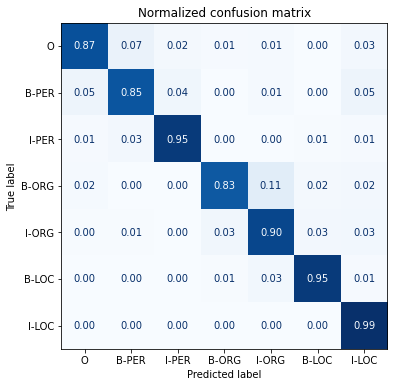

In [59]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

def plot_confusion_matrix(y_preds, y_true, labels):
    cm = confusion_matrix(y_true, y_preds, normalize='true')
    fig, ax = plt.subplots(figsize=(6, 6))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels = labels)
    disp.plot(cmap='Blues', values_format='.2f', ax=ax, colorbar = False)
    plt.title('Normalized confusion matrix')
    plt.show()

plot_confusion_matrix(df_tokens['labels'], df_tokens['predicted_label'], tags.names)

In [60]:
# sequences with high losses
def get_samples(df):
    for _, row in df.iterrows():
        labels, preds, tokens, losses = [], [], [], []
        for i, mask in enumerate(row['attention_mask']):
            if i not in {0, len(row['attention_mask'])}:
                labels.append(row['labels'][i])
                preds.append(row['predicted_label'][i])
                tokens.append(row['input_tokens'][i])
                losses.append(f"{row['loss'][i]:.2f}")
                
        df_tmp = pd.DataFrame({"tokens": tokens, "labels": labels, 
                               "preds": preds, "losses": losses}).T
        yield df_tmp

df["total_loss"] = df["loss"].apply(sum)
df_tmp = df.sort_values(by="total_loss", ascending=False).head(3)
  
for sample in get_samples(df_tmp):
    display(sample)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
tokens,▁',▁'',▁Τ,Κ,▁'',▁',▁',▁'',▁T,▁'',▁',ri,▁'',▁',k,▁'',▁',ala,</s>
labels,O,O,O,IGN,O,O,B-LOC,I-LOC,I-LOC,I-LOC,I-LOC,IGN,I-LOC,I-LOC,IGN,I-LOC,I-LOC,IGN,IGN
preds,O,O,B-ORG,I-ORG,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O
losses,0.00,0.00,4.95,0.00,0.00,0.00,10.41,9.13,7.91,8.11,8.58,0.00,8.48,8.80,0.00,9.11,9.32,0.00,0.00


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
tokens,▁'',8,.,▁Juli,▁'',▁:,▁Protest,camp,▁auf,▁dem,▁Gelände,▁der,▁Republika,n,ischen,▁Gar,de,</s>
labels,B-ORG,IGN,IGN,I-ORG,I-ORG,I-ORG,I-ORG,IGN,I-ORG,I-ORG,I-ORG,I-ORG,I-ORG,IGN,IGN,I-ORG,IGN,IGN
preds,O,O,O,O,O,O,O,O,O,O,O,O,B-ORG,I-ORG,I-ORG,I-ORG,I-ORG,O
losses,8.84,0.00,0.00,2.62,8.46,7.96,5.26,0.00,7.20,8.48,6.71,6.95,5.48,0.00,0.00,0.01,0.00,0.00


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
tokens,▁United,▁Nations,▁Multi,dimensional,▁Integra,ted,▁Stabil,ization,▁Mission,▁in,▁the,▁Central,▁African,▁Republic,</s>
labels,B-PER,I-PER,I-PER,IGN,I-PER,IGN,I-PER,IGN,I-PER,I-PER,I-PER,I-PER,I-PER,I-PER,IGN
preds,B-ORG,I-ORG,I-ORG,I-ORG,I-ORG,I-ORG,I-ORG,I-ORG,I-ORG,I-ORG,I-ORG,I-ORG,I-ORG,I-ORG,I-ORG
losses,5.82,5.29,5.44,0.00,5.39,0.00,5.37,0.00,5.13,5.64,5.55,5.69,5.40,5.41,0.00


In [61]:
# examine characters with opening parenthesis

df_tmp = df.loc[df['input_tokens'].apply(lambda x: u'\u2581(' in x)].head(2)
for sample in get_samples(df_tmp):
    display(sample)

,0,1,2,3,4,5
tokens,▁Ham,a,▁(,▁Unternehmen,▁),</s>
labels,B-ORG,IGN,I-ORG,I-ORG,I-ORG,IGN
preds,B-ORG,I-ORG,I-ORG,I-ORG,I-ORG,I-ORG
losses,0.02,0.00,0.01,0.01,0.01,0.00


,0,1,2,3,4,5,6,7
tokens,▁Kesk,kül,a,▁(,▁Mart,na,▁),</s>
labels,B-LOC,IGN,IGN,I-LOC,I-LOC,IGN,I-LOC,IGN
preds,B-LOC,I-LOC,I-LOC,I-LOC,I-LOC,I-LOC,I-LOC,I-LOC
losses,0.01,0.00,0.00,0.01,0.01,0.00,0.01,0.00


## Cross-Lingual Transfer

In [62]:
def get_f1_score(trainer, dataset):
    return trainer.predict(dataset).metrics['test_f1']

In [63]:
f1_scores = defaultdict(dict)
f1_scores['de']['de'] = get_f1_score(trainer, panx_de_encoded['test'])
print(f"F1-score of [de] model on [de] dataset: {f1_scores['de']['de']:.3f}")

F1-score of [de] model on [de] dataset: 0.872


In [64]:
# let's see how the model fared on a French text
text_fr = "Jeff Dean est informaticien chez Google en Californie"
tag_text(text_de, tags, trainer.model, xlmr_tokenizer)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
Tokens,<s>,▁Jeff,▁De,an,▁ist,▁ein,▁Informati,ker,▁bei,▁Google,▁in,▁Kaliforni,en,</s>
Tags,O,B-PER,I-PER,I-PER,O,O,O,O,O,B-ORG,O,B-LOC,I-LOC,O


In [65]:
# a function to evaluate language performance
def evaluate_lang_performance(lang, trainer):
    panx_ds = encode_panx_dataset(panx_ch[lang])
    return get_f1_score(trainer, panx_ds['test'])

In [66]:
f1_scores['de']['fr'] = evaluate_lang_performance('fr', trainer)
print(f"F1-score of [de] model on [fr] dataset: {f1_scores['de']['fr']:.3f}")

  0%|          | 0/3 [00:00<?, ?ba/s]

  0%|          | 0/3 [00:00<?, ?ba/s]

  0%|          | 0/5 [00:00<?, ?ba/s]

F1-score of [de] model on [fr] dataset: 0.743


In [67]:
f1_scores['de']['it'] = evaluate_lang_performance('it', trainer)
print(f"F1-score of [de] model on [it] dataset: {f1_scores['de']['it']:.3f}")

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

F1-score of [de] model on [it] dataset: 0.720


In [68]:
f1_scores['de']['en'] = evaluate_lang_performance('en', trainer)
print(f"F1-score of [de] model on [en] dataset: {f1_scores['de']['en']:.3f}")

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

F1-score of [de] model on [en] dataset: 0.648


In [70]:
del trainer
torch.cuda.empty_cache()

## When does zero-shot transfer make sense

In [71]:
# function to train on downsampled dataset
def train_on_subset(dataset, num_samples):
    train_ds = dataset['train'].shuffle(seed=42).select(range(num_samples))
    valid_ds = dataset['validation']
    test_ds = dataset['test']
    
    training_args.logging_steps = len(train_ds)//batch_size
    trainer = Trainer(model_init=model_init, args = training_args, data_collator=data_collator, compute_metrics=compute_metrics, 
                    train_dataset=train_ds, eval_dataset=valid_ds, tokenizer=xlmr_tokenizer)
    trainer.train()
    
    f1_score = get_f1_score(trainer, test_ds)
    return pd.DataFrame.from_dict({'num_samples': [len(train_ds)], 'f1_score': [f1_score]})

In [72]:
# let's encode the french dataset

panx_fr_encoded = encode_panx_dataset(panx_ch['fr'])
metrics_df = train_on_subset(panx_fr_encoded, 250)
metrics_df

  0%|          | 0/3 [00:00<?, ?ba/s]

/opt/conda/lib/python3.7/site-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use thePyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


Epoch,Training Loss,Validation Loss,F1
1,1.760900,1.327421,0.046692
2,1.287300,1.131906,0.130251
3,1.078500,1.061323,0.167194


,num_samples,f1_score
0,250,0.142281


In [73]:
# increasing samples to see how performance
for num_samples in [500, 1000, 2000, 4000]:
    metrics_df = metrics_df.append(train_on_subset(panx_fr_encoded, num_samples), ignore_index=True)

/opt/conda/lib/python3.7/site-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use thePyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


Epoch,Training Loss,Validation Loss,F1
1,1.530800,1.155474,0.198849
2,0.951400,0.746769,0.553458
3,0.666200,0.611905,0.633870


Epoch,Training Loss,Validation Loss,F1
1,1.174000,0.601250,0.583040
2,0.460600,0.449415,0.735301
3,0.325200,0.392786,0.768184


Epoch,Training Loss,Validation Loss,F1
1,0.818900,0.462325,0.719042
2,0.367900,0.369051,0.800075
3,0.230000,0.348099,0.819030


Epoch,Training Loss,Validation Loss,F1
1,0.607400,0.318901,0.804273
2,0.268000,0.292758,0.828904
3,0.176300,0.291618,0.851718


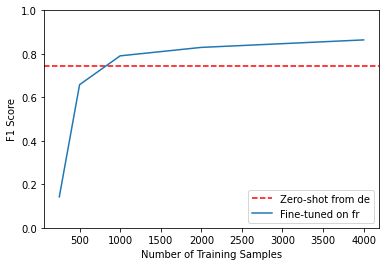

In [74]:
# plot the learning curve
fig, ax = plt.subplots()
ax.axhline(f1_scores["de"]["fr"], ls="--", color="r")
metrics_df.set_index("num_samples").plot(ax=ax)
plt.legend(["Zero-shot from de", "Fine-tuned on fr"], loc="lower right")
plt.ylim((0, 1))
plt.xlabel("Number of Training Samples")
plt.ylabel("F1 Score")
plt.show()

## Finetuning on Multiple Languages at once

In [75]:
from datasets import concatenate_datasets

def concatenate_splits(corpora):
    multi_corpus = DatasetDict()
    for split in corpora[0].keys():
        multi_corpus[split] = concatenate_datasets([corpus[split] for corpus in corpora]).shuffle(seed=42)
        
    return multi_corpus

panx_de_fr_encoded = concatenate_splits([panx_de_encoded, panx_fr_encoded])

In [77]:
# update the training arguments
training_args.logging_steps = len(panx_de_fr_encoded["train"]) // batch_size
training_args.output_dir = "xlm-roberta-base-finetuned-panx-de-fr"

# train on combined dataset
trainer = Trainer(model_init=model_init, args=training_args, data_collator=data_collator, compute_metrics=compute_metrics,
    tokenizer=xlmr_tokenizer, train_dataset=panx_de_fr_encoded["train"], eval_dataset=panx_de_fr_encoded["validation"])

trainer.train()

/opt/conda/lib/python3.7/site-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use thePyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


Epoch,Training Loss,Validation Loss,F1
1,0.284600,0.183738,0.835961
2,0.144600,0.161742,0.855397
3,0.092300,0.166374,0.866417


TrainOutput(global_step=2145, training_loss=0.173848366904092, metrics={'train_runtime': 427.9405, 'train_samples_per_second': 120.297, 'train_steps_per_second': 5.012, 'total_flos': 1141210163165184.0, 'train_loss': 0.173848366904092, 'epoch': 3.0})

In [78]:
# now let's evaluate performance of combined de-fr dataset on each language
for lang in langs:
    f1 = evaluate_lang_performance(lang, trainer)
    print(f"F1-score of [de-fr] model on [{lang}] dataset: {f1:.3f}")

  0%|          | 0/7 [00:00<?, ?ba/s]

F1-score of [de-fr] model on [de] dataset: 0.879
F1-score of [de-fr] model on [fr] dataset: 0.886
F1-score of [de-fr] model on [it] dataset: 0.816
F1-score of [de-fr] model on [en] dataset: 0.721


In [79]:
del trainer
torch.cuda.empty_cache()

### Comparison

In [80]:
corpora = [panx_de_encoded]

# Exclude German from iteration
for lang in langs[1:]:
    training_args.output_dir = f"xlm-roberta-base-finetuned-panx-{lang}"
    # Fine-tune on monolingual corpus
    ds_encoded = encode_panx_dataset(panx_ch[lang])
    metrics = train_on_subset(ds_encoded, ds_encoded["train"].num_rows)
    # Collect F1-scores in common dict
    f1_scores[lang][lang] = metrics["f1_score"][0]
    # Add monolingual corpus to list of corpora to concatenate
    corpora.append(ds_encoded)

Epoch,Training Loss,Validation Loss,F1
1,0.585100,0.320246,0.820406
2,0.256000,0.286205,0.849926
3,0.172500,0.269147,0.845573


Epoch,Training Loss,Validation Loss,F1
1,0.811800,0.347082,0.750326
2,0.286900,0.267908,0.829948
3,0.176200,0.239979,0.852483


Epoch,Training Loss,Validation Loss,F1
1,1.147200,0.581958,0.560308
2,0.518600,0.410479,0.726061
3,0.359900,0.381367,0.765112


In [81]:
corpora_encoded = concatenate_splits(corpora)

In [82]:
training_args.logging_steps = len(corpora_encoded["train"]) // batch_size
training_args.output_dir = "xlm-roberta-base-finetuned-panx-all"

trainer = Trainer(model_init=model_init, args=training_args,
    data_collator=data_collator, compute_metrics=compute_metrics,
    tokenizer=xlmr_tokenizer, train_dataset=corpora_encoded["train"],
    eval_dataset=corpora_encoded["validation"])

trainer.train()

Epoch,Training Loss,Validation Loss,F1
1,0.303600,0.188781,0.822159
2,0.158500,0.176281,0.854624
3,0.102700,0.174798,0.864190


TrainOutput(global_step=2505, training_loss=0.18818682313203336, metrics={'train_runtime': 497.389, 'train_samples_per_second': 120.751, 'train_steps_per_second': 5.036, 'total_flos': 1307706056009472.0, 'train_loss': 0.18818682313203336, 'epoch': 3.0})

In [83]:
for idx, lang in enumerate(langs):
    f1_scores["all"][lang] = get_f1_score(trainer, corpora[idx]["test"])

In [84]:
scores_data = {"de": f1_scores["de"],"each": {lang: f1_scores[lang][lang] for lang in langs},
               "all": f1_scores["all"]}
f1_scores_df = pd.DataFrame(scores_data).T.round(4)
f1_scores_df.rename_axis(index="Fine-tune on", columns="Evaluated on",
                         inplace=True)
f1_scores_df

Evaluated on,de,fr,it,en
Fine-tune on,,,,
de,0.8718,0.7431,0.7198,0.6484
each,0.8718,0.8627,0.8291,0.7060
all,0.8743,0.8943,0.8740,0.7872
